# ARIMA Model

## Parameters

In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os  

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess 

## Moving Average MA(q = 2)

$$y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2}$$

Adfuller Test Statistic: -11.591499931045089
Adfuller P Value: 2.7848111295002507e-21


Text(0, 0.5, 'Autocorrelation')

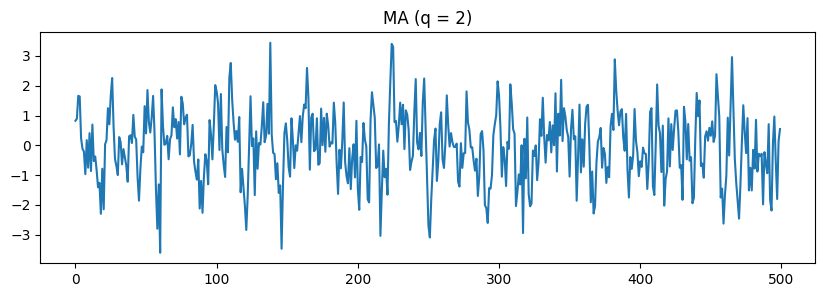

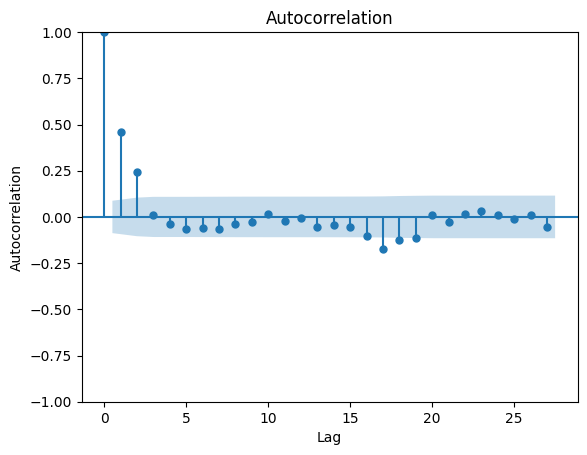

In [23]:
np.random.seed(666)    

mu = 1 
theta_1 = 0.5
theta_2 = 0.3

ma2 = np.array([mu, theta_1, theta_2])                                           
ar2 = np.array([1]) # Set to 0 because we only want MA                                  
 
ma_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)

# ADFuller Test 
result = adfuller(ma_process)
adf_statistic = result[0]
p_value = result[1]
print(f'Adfuller Test Statistic: {adf_statistic}')
print(f'Adfuller P Value: {p_value}')

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(ma_process)
plt.title("MA (q = 2)")

# Plot ACF 
plot_acf(ma_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

After Lag 2 the autocorrelation becomes non significant, therefore we face an MA(q = 2) process.

## Autoregressive AR(p = 2)

$$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2}$$

Adfuller Test Statistic: -6.670732090925169
Adfuller P Value: 4.594973390002015e-09


Text(0, 0.5, 'Autocorrelation')

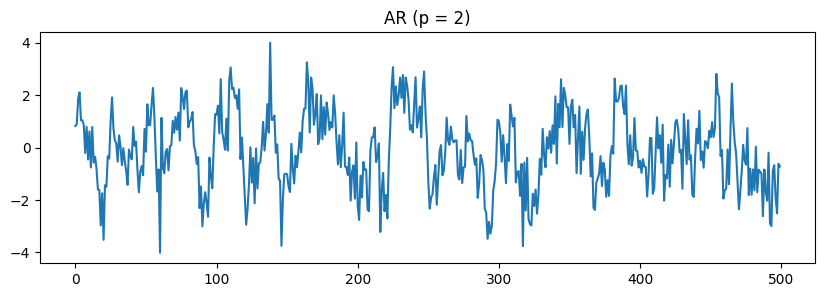

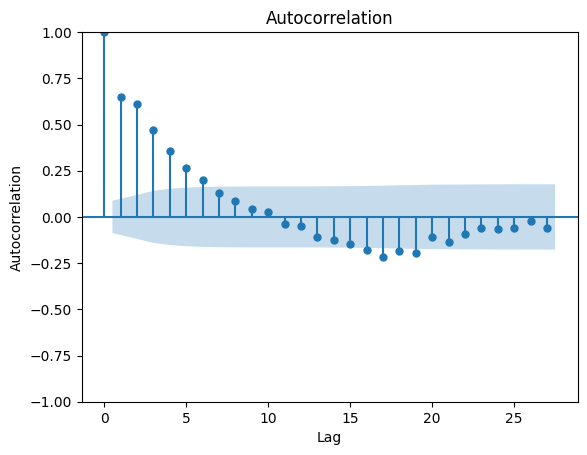

In [24]:
np.random.seed(666)    

mu = 1 
phi_1 = 0.5
phi_2 = 0.3

ma2 = np.array([1, 0 ,0])                                    
ar2 = np.array([mu, -phi_1, -phi_2])                                 
 
ar_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)

# ADFuller Test 
result = adfuller(ar_process)
adf_statistic = result[0]
p_value = result[1]
print(f'Adfuller Test Statistic: {adf_statistic}')
print(f'Adfuller P Value: {p_value}')

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(ar_process)
plt.title("AR (p = 2)")

# Plot ACF 
plot_acf(ar_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

Sinusoidal/decaying pattern, this is not a MA process.

Text(0, 0.5, 'Autocorrelation')

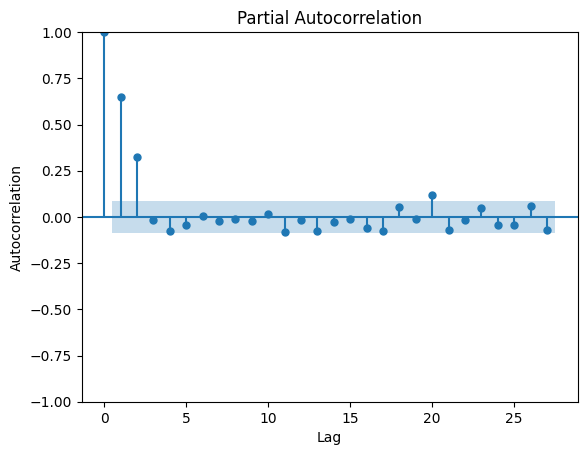

In [25]:
# Plot PACF 
plot_pacf(ar_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

Abruptly non significant after lag p = 2, this is an AR process.

## ARMA(p = 2, q = 2)

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t + \theta_1 \epsilon_{t-1} $$

Adfuller Test Statistic: -7.410507407904895
Adfuller P Value: 7.154925339433269e-11


Text(0, 0.5, 'Autocorrelation')

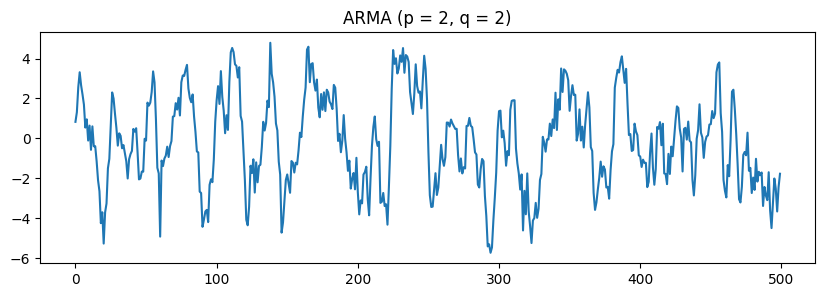

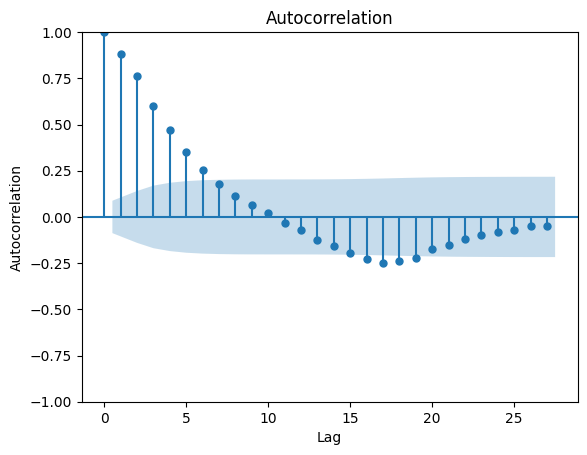

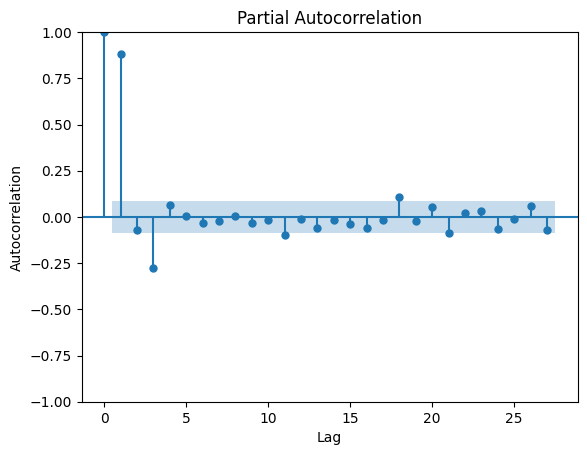

In [26]:
np.random.seed(666)    

mu = 1 
phi_1 = 0.5
phi_2 = 0.3

theta_1 = 0.5
theta_2 = 0.3

ma2 = np.array([mu, theta_1 , theta_2])                                    
ar2 = np.array([mu, -phi_1, -phi_2])                                 
 
arma_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)

# ADFuller Test 
result = adfuller(arma_process)
adf_statistic = result[0]
p_value = result[1]
print(f'Adfuller Test Statistic: {adf_statistic}')
print(f'Adfuller P Value: {p_value}')

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(arma_process)
plt.title("ARMA (p = 2, q = 2)")

# Plot ACF 
plot_acf(arma_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# Plot pACF 
plot_pacf(arma_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

ACF and PACF doesn't allow us to conclude anything. Therefore, we are facing an ARMA process.

## Real Data

In [27]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)

    return df 

df = read_dataset()
df

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


In [28]:
ts_variable = "Passengers"
date_variable = "date"

In [29]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.8)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
110,362,1958-03-01
111,348,1958-04-01
112,363,1958-05-01
113,435,1958-06-01


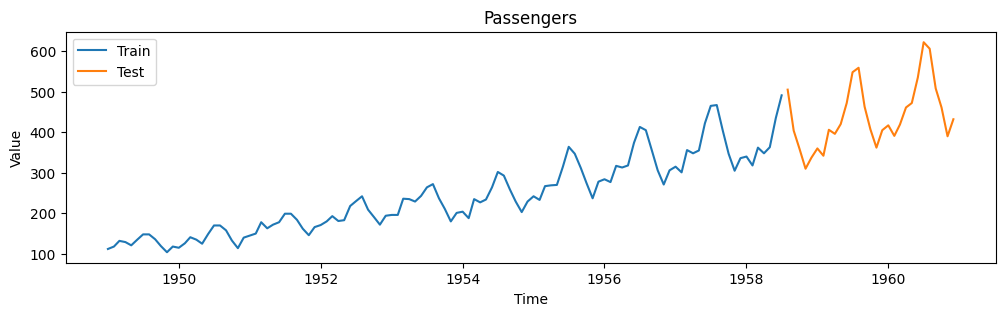

In [30]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("img/time_series_train_and_test.png", dpi = 300, bbox_inches='tight')  
plt.show() 

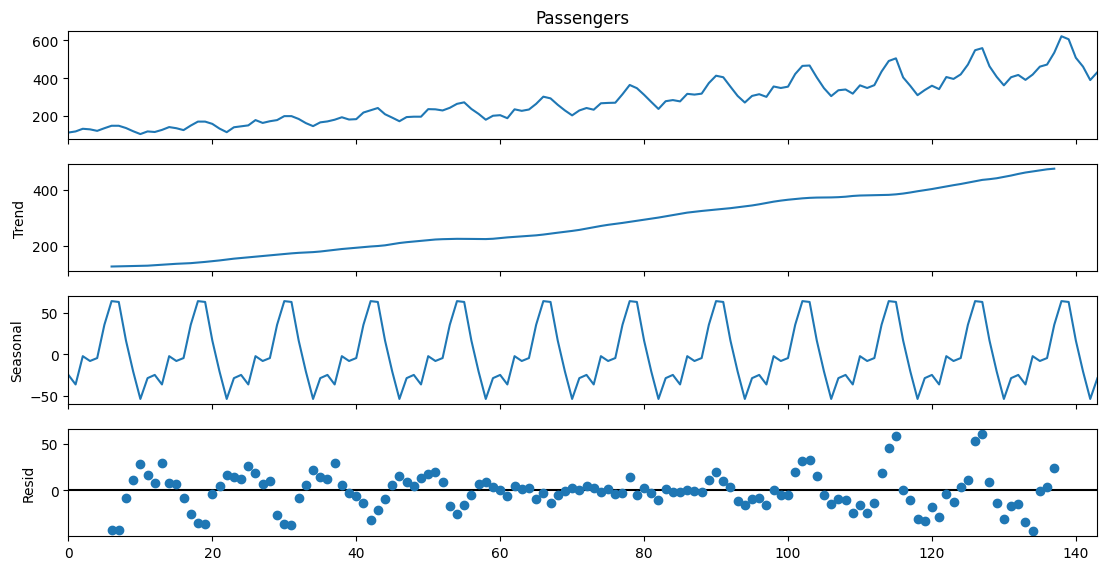

In [31]:
decomp = seasonal_decompose(df[ts_variable], model='additive', period = 12)
fig = decomp.plot()
fig.set_size_inches((12, 6))
plt.show()

### Log Transform

In [32]:
train[f"{ts_variable}_log"] = np.log(train[ts_variable])
ts_variable = ts_variable + "_log"
train

,Passengers,date,Passengers_log
0,112,1949-01-01,4.718499
1,118,1949-02-01,4.770685
2,132,1949-03-01,4.882802
3,129,1949-04-01,4.859812
4,121,1949-05-01,4.795791
...,...,...,...
110,362,1958-03-01,5.891644
111,348,1958-04-01,5.852202
112,363,1958-05-01,5.894403
113,435,1958-06-01,6.075346


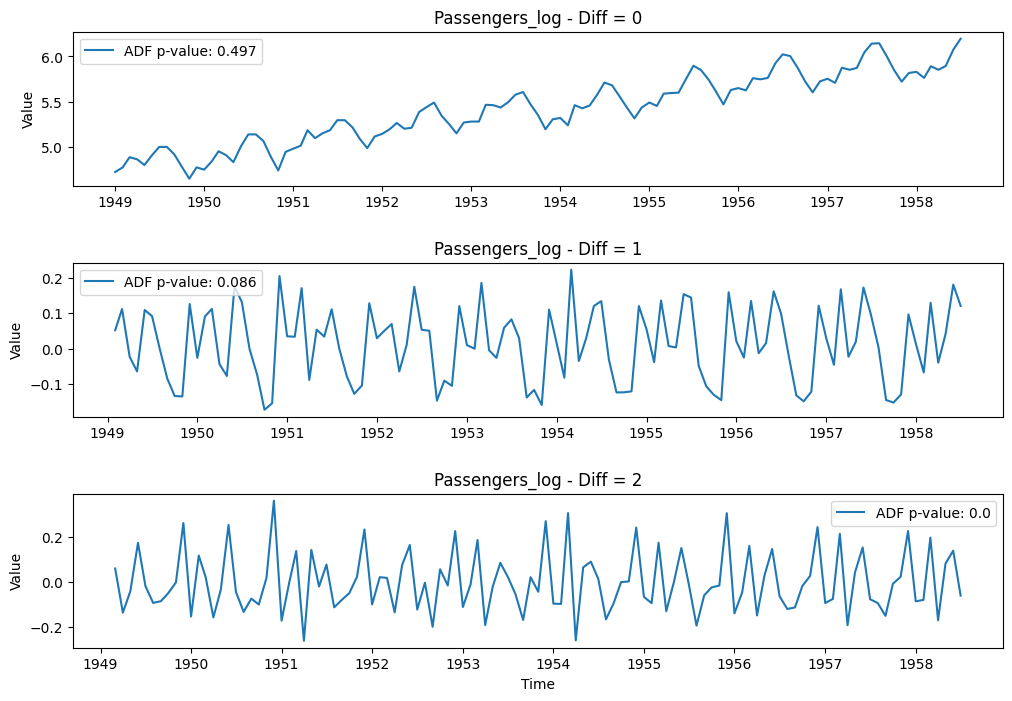

In [33]:
diff_list = [0,1,2]

fig, axs = plt.subplots(len(diff_list), 1, figsize = (12,8))
fig.subplots_adjust(hspace=0.5)

for i in diff_list: 
    
    # Diff
    if i == 0:
        train[f'{ts_variable}_diff_0'] = train[f'{ts_variable}']
    else:
        train[f'{ts_variable}_diff_{i}'] = train[f'{ts_variable}_diff_{i-1}'].diff()

    # Statistical Test - Augmented Dickey-Fulley Test
    result = adfuller(train[f'{ts_variable}_diff_{i}'].dropna())
    adf_statistic = result[0]
    p_value = result[1]

    # Time Series Plot 
    axs[i].plot(train[date_variable], train[f'{ts_variable}_diff_{i}'] , label = f'ADF p-value: {round(p_value, 3)}')
    axs[i].set_title(f"{ts_variable} - Diff = {i}")
    axs[i].set_ylabel("Value")
    axs[i].legend()

plt.xlabel("Time")
plt.savefig("img/time_series_differentiation.png", dpi = 300, bbox_inches='tight')
plt.show()

At d = 2 the data becomes stationary.

### ACF Plot

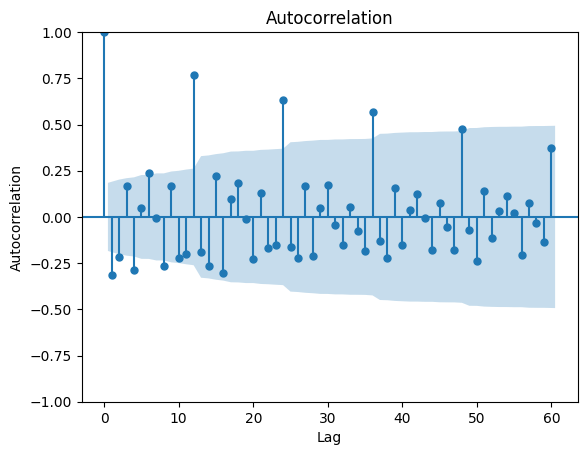

In [34]:
plot_acf(train[f'{ts_variable}_diff_2'].dropna(), lags = 60)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("img/autocorrelation.png", dpi = 300, bbox_inches='tight')

Sinusoidal Pattern, can't conclude MA process. The estimated $q$ value is $q = 12$

### PACF Plot

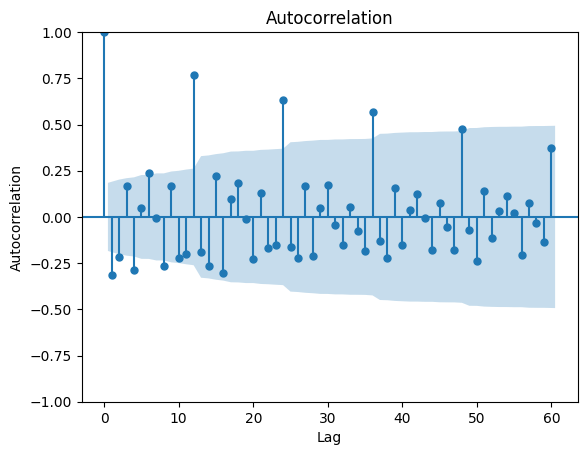

In [35]:
plot_acf(train[f'{ts_variable}_diff_2'].dropna(), lags = 60)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("img/partial_autocorrelation.png", dpi = 300, bbox_inches='tight')

Can't conclude AR process. The estimated $p$ value is $p = 12$

### ARIMA(p, d, q)

In [36]:
# Arima Naive 
ts_variable = "Passengers_log"

p = 12
d = 2
q = 12

model_naive = ARIMA(train[f"{ts_variable}"], order=(1, 1, 1))
model_optimal = ARIMA(train[f"{ts_variable}"], order=(p,d,q))

model_naive_fit = model_naive.fit()
model_optimal_fit = model_optimal.fit()

/Users/bmoreno/miniforge3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bmoreno/miniforge3/envs/data-science/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         Passengers_log   No. Observations:                  115
Model:               ARIMA(12, 2, 12)   Log Likelihood                 178.978
Date:                Tue, 17 Dec 2024   AIC                           -307.955
Time:                        12:30:41   BIC                           -239.771
Sample:                             0   HQIC                          -280.287
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1048      1.524     -0.069      0.945      -3.092       2.883
ar.L2         -0.2211      1.596     -0.139      0.890      -3.349       2.907
ar.L3          0.1300      1.658      0.078      0.9

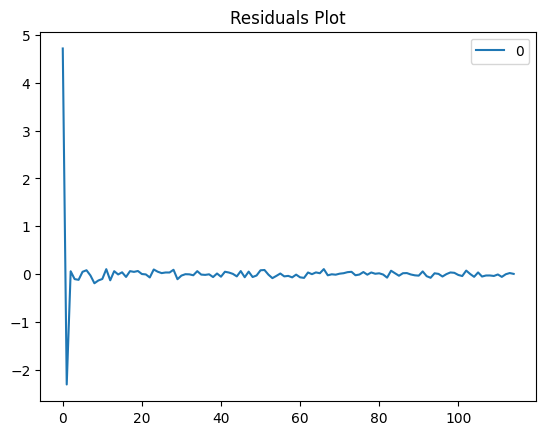

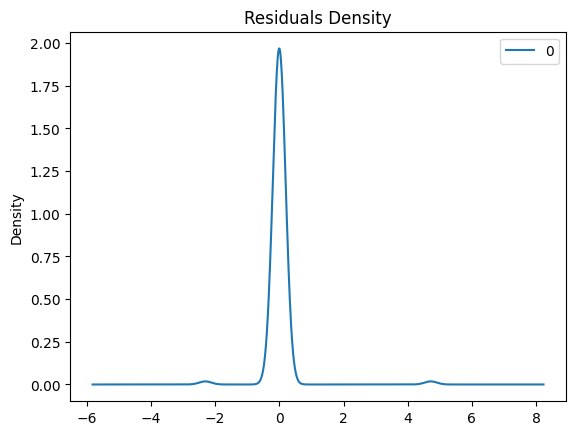

                0
count  115.000000
mean     0.017125
std      0.494638
min     -2.307064
25%     -0.037546
50%     -0.003123
75%      0.035092
max      4.718499


In [37]:
# Summary of fit Model 
print(model_optimal_fit.summary())
# Residuals Plot
residuals = pd.DataFrame(model_optimal_fit.resid)
residuals.plot()
plt.title("Residuals Plot")
plt.show()
# Density plot Residuals
residuals.plot(kind='kde')
plt.title("Residuals Density")
plt.show()
# summary stats of residuals
print(residuals.describe())

In [38]:
train["prediction_optimal"] = model_optimal_fit.predict(start=0, end=len(train))
train["prediction_naive"] = model_naive_fit.predict(start=0, end=len(train))
train["prediction_optimal_exp"] = np.exp(train["prediction_optimal"])
train["prediction_naive_exp"] = np.exp(train["prediction_naive"])

test["prediction_optimal"] = model_optimal_fit.forecast(steps = len(test))
test["prediction_naive"] = model_naive_fit.forecast(steps = len(test))
test["prediction_optimal_exp"] = np.exp(test["prediction_optimal"])
test["prediction_naive_exp"] = np.exp(test["prediction_naive"])
test

,Passengers,date,prediction_optimal,prediction_naive,prediction_optimal_exp,prediction_naive_exp
115,505,1958-08-01,6.187317,6.214667,486.539166,500.029475
116,404,1958-09-01,6.017403,6.204240,410.511252,494.842938
117,359,1958-10-01,5.894560,6.210206,363.056942,497.803905
118,310,1958-11-01,5.805383,6.206793,332.082205,496.107563
119,337,1958-12-01,5.865794,6.208746,352.762196,497.077453
120,360,1959-01-01,5.879042,6.207628,357.466758,496.522278
121,342,1959-02-01,5.817177,6.208268,336.022139,496.839857
122,406,1959-03-01,5.953522,6.207902,385.107146,496.658123
123,396,1959-04-01,5.911667,6.208111,369.321349,496.762098
124,420,1959-05-01,5.922066,6.207991,373.181980,496.702604


In [39]:
# Fix the D values missing. 
train = train[d:]

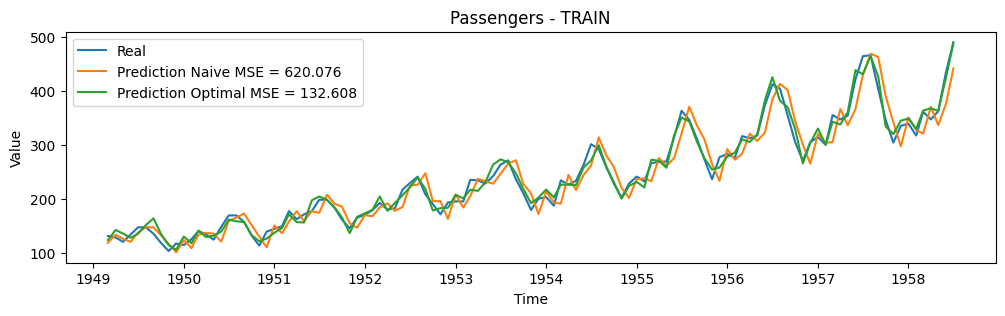

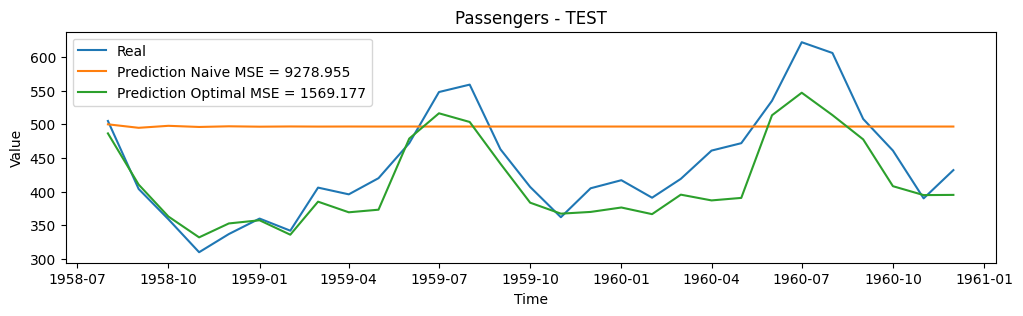

In [40]:
ts_variable = "Passengers"
mse_train_naive = mean_squared_error(train[ts_variable], train['prediction_naive_exp'])
mse_train_optimal = mean_squared_error(train[ts_variable], train['prediction_optimal_exp'])

mse_test_naive = mean_squared_error(test[ts_variable], test['prediction_naive_exp'])
mse_test_optimal = mean_squared_error(test[ts_variable], test['prediction_optimal_exp'])

plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Real')
plt.plot(train[date_variable], train["prediction_naive_exp"], label = f"Prediction Naive MSE = {round(mse_train_naive,3)}")
plt.plot(train[date_variable], train["prediction_optimal_exp"], label = f"Prediction Optimal MSE = {round(mse_train_optimal,3)}")
plt.title(f"{ts_variable} - TRAIN")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[ts_variable], label = f'Real')
plt.plot(test[date_variable], test["prediction_naive_exp"], label = f"Prediction Naive MSE = {round(mse_test_naive,3)}")
plt.plot(test[date_variable], test["prediction_optimal_exp"], label = f"Prediction Optimal MSE = {round(mse_test_optimal,3)}")
plt.title(f"{ts_variable} - TEST")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

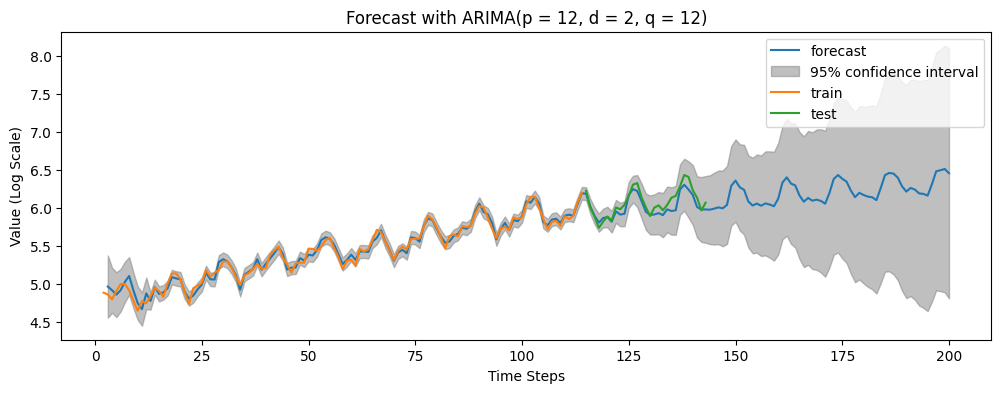

In [41]:
fig, ax = plt.subplots(figsize = (12,4))
plot_predict(model_optimal_fit, 3, 200, ax = ax)
ax.plot(range(2, len(train[date_variable]) + 2), np.log(train[ts_variable]), label = f'train')
ax.plot(range(115, 115 + len(test[date_variable])), np.log(test[ts_variable]), label = f'test')
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value (Log Scale)")
plt.title("Forecast with ARIMA(p = 12, d = 2, q = 12)")
plt.savefig("img/arima_results.png", dpi = 300, bbox_inches='tight')